/var/folders/8_/lltwgz4x48ncx3q3k86fr_tm0000gq/T/ipykernel_37404/819144707.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH, 

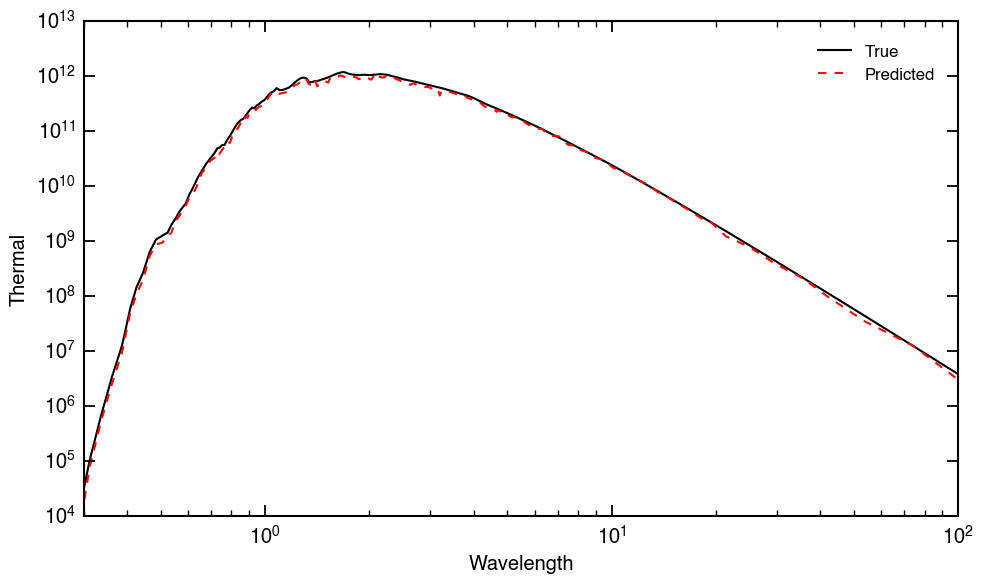

In [15]:
import sys
sys.path.append('../src')

import json
from pathlib import Path
import glob
import torch
import numpy as np
import matplotlib.pyplot as plt
from model import create_prediction_model
from normalizer import DataNormalizer

# Paths
DATA_PATH = "../data/normalized_profiles"
METADATA_PATH = "../data/normalized_profiles/normalization_metadata.json"
MODEL_PATH = "../data/model/best_model.pt"
CONFIG_PATH = "../inputs/model_input_params.jsonc"

# Load files
with open(CONFIG_PATH, 'r') as f:
    config = json.load(f)
with open(METADATA_PATH, 'r') as f:
    metadata = json.load(f)

# Load model
model = create_prediction_model(config)
model.load_state_dict(torch.load(MODEL_PATH, map_location='cpu')['state_dict'], strict=False)

# Get variables
input_vars = config["input_variables"]
target_var = config["target_variables"][0]
wave_var = "wavenumber"

# Get a sample profile
profile_files = glob.glob(DATA_PATH + "/*.json")

with open(profile_files[3], 'r') as f:
    profile = json.load(f)

# Create inputs dict
inputs = {}
for seq_type, indices in config.get("sequence_types", {}).items():
    features = []
    for idx in indices:
        values = profile.get(input_vars[idx], [0])
        features.append(torch.tensor(values, dtype=torch.float32))
    if features:
        inputs[seq_type] = torch.stack(features, dim=1).unsqueeze(0)

if config.get("global_feature_indices"):
    global_values = []
    for idx in config["global_feature_indices"]:
        val = profile.get(input_vars[idx], 0)
        global_values.append(float(val) if not isinstance(val, list) else float(val[0]))
    inputs["global"] = torch.tensor(global_values, dtype=torch.float32).unsqueeze(0)

# Get predictions
with torch.no_grad():
    predictions = model(inputs).squeeze(0).cpu().numpy()

# Get true values and wavenumbers
true_vals = profile.get(target_var, [])
wave_vals = profile.get(wave_var, [])

# Denormalize
true_denorm = DataNormalizer.denormalize(true_vals, metadata, target_var)
pred_denorm = DataNormalizer.denormalize(predictions, metadata, target_var)
wave_denorm = DataNormalizer.denormalize(wave_vals, metadata, wave_var)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(1e4/np.asarray(wave_denorm), true_denorm, 'k-', label='True')
plt.plot(1e4/np.asarray(wave_denorm), pred_denorm, 'r--', label='Predicted')
plt.xscale('log')
plt.ylim(1e4, 1e13)
plt.xlim(0.3, 100)

plt.yscale('symlog')
plt.xlabel('Wavelength')
plt.ylabel('Thermal')
plt.legend()
plt.tight_layout()
plt.savefig("thermal_vs_wavenumber.png")
plt.show()

Inference took 0.0340 seconds.


/opt/homebrew/Caskroom/miniforge/base/envs/nn/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/var/folders/8_/lltwgz4x48ncx3q3k86fr_tm0000gq/T/ipykernel_37404/4214891688.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via t

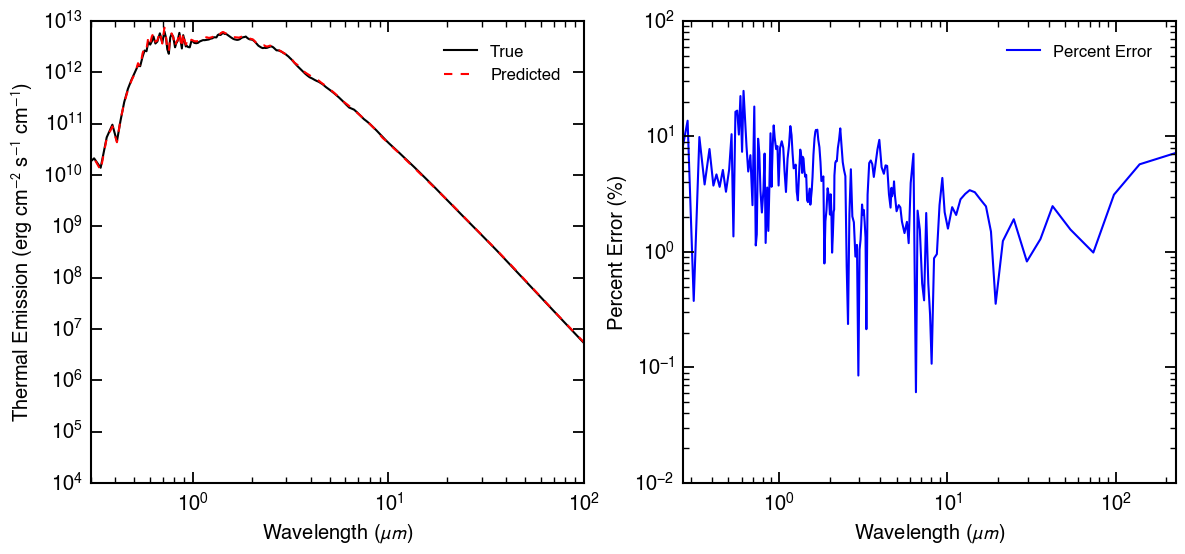

In [16]:
import sys
sys.path.append('../src')

import json
import time
import random
from pathlib import Path
import glob
import torch
import numpy as np
import matplotlib.pyplot as plt
from model import create_prediction_model
from normalizer import DataNormalizer

plt.style.use('science.mplstyle')

# Paths (adjust if necessary)
DATA_PATH = "../data/normalized_profiles"
METADATA_PATH = "../data/normalized_profiles/normalization_metadata.json"
MODEL_PATH = "../data/model/best_model.pt"
CONFIG_PATH = "../inputs/model_input_params.jsonc"

# Load configuration and normalization metadata
with open(CONFIG_PATH, 'r') as f:
    config = json.load(f)
with open(METADATA_PATH, 'r') as f:
    metadata = json.load(f)

# Create and load the model, then set it to evaluation mode
model = create_prediction_model(config)
model.load_state_dict(torch.load(MODEL_PATH, map_location='cpu')['state_dict'], strict=False)
model.eval()

# Get variable names from the configuration
input_vars = config["input_variables"]
target_var = config["target_variables"][0]
wave_var = "wavenumber"  # assuming the profile contains this key

# Select a single random profile
profile_files = glob.glob(DATA_PATH + "/*.json")
if not profile_files:
    raise FileNotFoundError("No profile files found in the specified data path.")
random_profile_file = random.choice(profile_files)
with open(random_profile_file, 'r') as f:
    profile = json.load(f)

# Build the inputs dictionary for the model
inputs = {}
# Process sequence types defined in the configuration
for seq_type, indices in config.get("sequence_types", {}).items():
    features = []
    for idx in indices:
        # Get the data; if missing, use a default value
        values = profile.get(input_vars[idx], [0])
        features.append(torch.tensor(values, dtype=torch.float32))
    if features:
        # Stack features along the feature dimension and add a batch dimension
        inputs[seq_type] = torch.stack(features, dim=1).unsqueeze(0)

# Process global features if defined
if config.get("global_feature_indices"):
    global_values = []
    for idx in config["global_feature_indices"]:
        val = profile.get(input_vars[idx], 0)
        global_values.append(float(val) if not isinstance(val, list) else float(val[0]))
    inputs["global"] = torch.tensor(global_values, dtype=torch.float32).unsqueeze(0)

# Run inference and time it
start_time = time.time()
with torch.no_grad():
    predictions = model(inputs).squeeze(0).cpu().numpy()
inference_time = time.time() - start_time
print(f"Inference took {inference_time:.4f} seconds.")

# Get true target values and wavenumber values from the profile
true_vals = profile.get(target_var, [])
wave_vals = profile.get(wave_var, [])



# Denormalize true values, predictions, and wavenumbers using the stored metadata
true_denorm = DataNormalizer.denormalize(true_vals, metadata, target_var)
pred_denorm = DataNormalizer.denormalize(predictions, metadata, target_var)
wave_denorm = DataNormalizer.denormalize(wave_vals, metadata, wave_var)



# Convert to numpy arrays for plotting
true_denorm = np.array(true_denorm)
pred_denorm = np.array(pred_denorm)
# Compute wavelength from wavenumber (assuming wavenumber is in reciprocal units)
wavelength = 1e4 / np.asarray(wave_denorm)

# Compute the percent error (point-wise) as |true - pred|/true * 100.
percent_error = np.abs((true_denorm - pred_denorm[:,0]) / true_denorm) * 100



# Plot the results in a two-panel figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Left subplot: True vs. Predicted Thermal vs. Wavelength
ax1.plot(wavelength, true_denorm, 'k-', label='True')
ax1.plot(wavelength, pred_denorm, 'r--', label='Predicted')
ax1.set_xscale('log')
ax1.set_yscale('symlog')
ax1.set_xlim(0.3, 100)
ax1.set_ylim(1e4, 1e13)
ax1.set_xlabel(r'Wavelength ($\mu m$)')
ax1.set_ylabel('Thermal')
ax1.set_ylabel(r'Thermal Emission (erg cm$^{-2}$ s$^{-1}$ cm$^{-1}$)')

ax1.legend()

# Right subplot: Percent Error vs. Wavelength
ax2.plot(wavelength, percent_error, 'b-', label='Percent Error')
ax2.set_xscale('log')
ax2.set_xlabel(r'Wavelength ($\mu m$)')
ax2.set_ylabel('Percent Error (%)')
ax2.set_yscale('log')
ax2.set_ylim(1e-2, 1e2)

ax2.legend()
